In this Notebook we will implement a basic version of Gaussian Processes.

For this, recall a Gaussian Process is a Stochastic process, where each (finite) subset of Datapoints $D = \{x_i\}_i$ is distributed to some Normal (Gaussian ) distribution: $D \sim N(\mu_u, \Sigma_i)$, where $\mu$ and $\Sigma$ are the mean and (co-)variance respectively.

Implementing a Gaussian Process is more a mathematical than an Computational Problem, making it efficient is however not that straightforward. In the following we make no claim of computational optimality, so if you intend to use Gaussian Processes in your application, be advised to use one of the many fantastic, already existing Packages.

In this project we will be using JAX.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import config
#config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)
from functools import partial

We will approximate the following function:

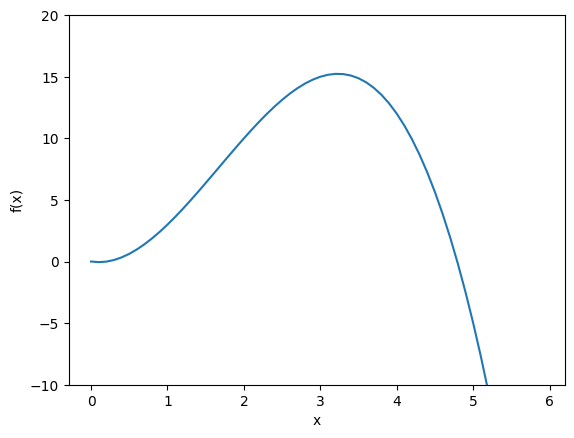

In [2]:
def f(x):
    return -x**3 + 5*x**2 -x 

import matplotlib.pyplot as plt
xx = jnp.arange(0., 6, 0.1)
yy = [f(x) for x in xx]
fig = plt.figure()
plt.plot(xx,yy)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-10,20);
plt.show()

The biggest task in using Gaussian Processes is using an appropriate Kernel Function.
In the following, we implement some for later use:

    - RBF kernel (Eucilidic distance)
    - ARD kernel (Mahalanobis distance)
    -

In [3]:
#@jax.jit
def rbf_kernel(x, y, l=0.1):
    return jnp.exp(-jnp.divide(jnp.vdot(x-y,x-y), 2*jnp.power(l,2)))

#@jax.jit
def ARD_kernel(x,y, sigma_inv ,l=0.1):
    return jnp.exp(
        -jnp.divide(
        jnp.vdot((x-y), sigma_inv @ (x-y)) ,  2*jnp.power(l,2)
        )
    )

For Inference, we will need to calculate the conditionial expectation $\mu$ and the conditional variance $\Sigma$:

In [4]:
def Gram_XX(D, kernel):
    #Calculates the Gram matrix of the Data
    #return jnp.array([kernel(x,y) for x in D for y in D]).reshape(len(D),len(D))
    f1 = jax.vmap(kernel, (None, 0))
    return jax.vmap(f1, (0, None))(D,D)


@partial(jax.jit, static_argnames=['kernel'])
def K_TXstar(x,D, kernel):
    s = jax.vmap(kernel,(None, 0))
    return s(x, D)

@partial(jax.jit, static_argnames=['kernel'])
def Sigma_starstar_L(x, kernel, ktxstar, L):        
    v = jnp.linalg.solve(L, ktxstar)
    return (kernel(x,x) - jnp.vdot(v,v))

#Calculates the variance of the posterior p(x|D)
@partial(jax.jit, static_argnames=['kernel'])
def post_variance(x, D, kernel, L):
    ktx = K_TXstar(x, D, kernel)
    v = jnp.linalg.solve(L, ktx)
    variances =  (kernel(x,x) - jnp.vdot(v,v))
    variances = jnp.abs(variances)
    return variances

@partial(jax.jit, static_argnames=['kernel'])
def posterior_mean(x, prior_mean_x, D, fd, prior_mean_D, kernel, L):
    ktx = K_TXstar(x, D, kernel)
    y = fd - prior_mean_D
    v = jnp.linalg.solve(L, y)
    alpha = jnp.linalg.solve(L.T, v)
    return prior_mean_x + ktx @ alpha


#Following: Used for the Optimization:
#wrapper around post_variance that calculates the sum of the variances
@partial(jax.jit, static_argnames=['kernel'])
def __std_loss(xx, D, kernel, Lxx):
    variances =  jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, Lxx)
    variances = jnp.abs(variances) #we dont expect negative variances, and if they are to appear, they should be due to numerical errors on the scale of 1e-16, so we dont really care.
    losses = jnp.sqrt(variances)
    stepsize = xx[1]-xx[0]
    return jnp.sum(losses)*stepsize

#wrapper around __variance_loss, includes the calculation of the Cholesky decomposition of the Gram matrix of D
@partial(jax.jit, static_argnames=['kernel'])
def std_loss_calculator(xx, D, kernel):
    Lxx = jnp.linalg.cholesky(Gram_XX(D, kernel))
    return __std_loss(xx, D, kernel, Lxx)

Let us know check that we can Indeed obtain the posterior Mean and standard diviations, e.g. we can find an approximate $\hat{f}(x)$ represented by the $GP$.

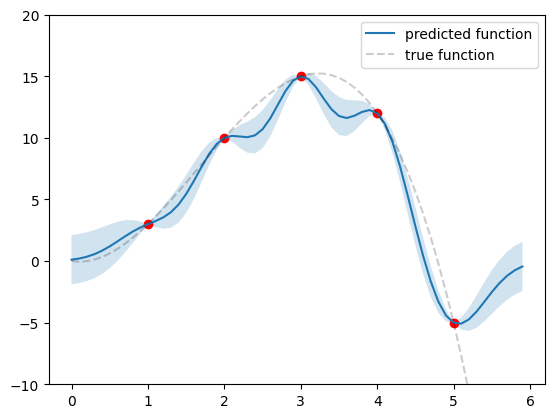

In [5]:
#D: x values we condition on
D = jnp.array([1., 2., 3., 4., 5.])
fd = jnp.array([f(x) for x in D])

kernel = lambda x, y : rbf_kernel(x, y, l= 0.4)
L = jnp.linalg.cholesky(Gram_XX(D, kernel))
ys = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, L)
stds = jnp.sqrt(vars)
plt.plot(xx, ys, label='predicted function')
plt.plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
plt.fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
plt.scatter(D, fd, color='red')
plt.ylim(-10,20)
plt.legend()

# Active Learning

In active learning the goal is to approximate a function $f(x)$ to the best of our possibilities, while keeping the needed function evaluations to a minimum; one (propably not optimal, but acceccisble) approach is to queuery for the points with lowest confidence = largest variance.


Consinder the problem of finding the optimal support positions for a gaussian Process:
Without any Datapoints to condition on, it follows the posterior, in our case $x\sim \mathcal{0,1}$

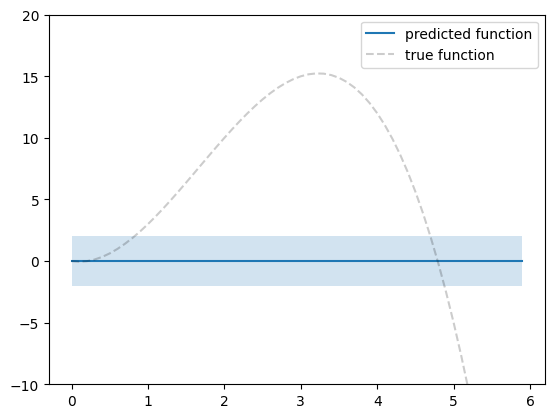

In [6]:
figure = plt.figure()
plt.plot(xx, jnp.zeros_like(xx), label='predicted function')
stds = jnp.ones(xx.shape)
plt.plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
plt.fill_between(
        xx, 
        0. - 2*stds,  # 95% confidence interval
        0. + 2*stds,
        alpha=0.2    # transparency
    )
plt.ylim(-10,20)
plt.legend()


What are the Best points to achieve a good representation of $f(x)$?

With the example from above, we can:

    1.) select a point of maximum merit
    2.) compute f(x)
    3.) condition the GP on (x, f(x))
    4.) repeat until profit

In [7]:
#SETTINGS FOR THE PROBLEM
lower_domain_limit = 0
upper_domain_limit = 6
xx = jnp.arange(lower_domain_limit, upper_domain_limit, 0.1)
xx_fine = jnp.arange(lower_domain_limit, upper_domain_limit, 0.01)  

1.) choose a random point. Due to implementation limitations, we do not actually draw from the gaussian process; however since it is not conditioned on anything, we can just draw according to our prior (which we assume as $\mathcal{N}(0,1)$, and hence $x_1 \sim$ Uni $(D)$ with D the domain of intrest).


In [8]:
key = jax.random.PRNGKey(0)
x_0 = jax.random.uniform(key, (1,), minval = lower_domain_limit, maxval = upper_domain_limit)

2.) In this example, we can just call the python function $f(x)$; however in general this may be arbitrary complex, e.g. running a COMSOL simulation, train a ML model or whatever we want.

In [9]:
y_0 = f(x_0)

3.) Now we need to condition on (x, f(x)), that is calculate $m_{\star | X}$ and $\Sigma_{\star | X}$. We will calculate most of it during the prediction call; however it is smart to precalculate the expensive (and constant parts) of the expression $L$:
(L is the Cholesky decomposition of our Gram Matrix, and as such scales with $N^3$, hence we want to cache the calculation before using it in the prediction step, which then goes with $N^2$)

In [10]:
D = jnp.array(x_0)
fd = jnp.array(y_0)
kernel = lambda x,y : rbf_kernel(x,y, l=0.4)
L = jnp.linalg.cholesky(Gram_XX(D, kernel))

We then can make a prediction:

In [11]:
mus = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, L)
stds = jnp.sqrt(vars)

Text(0, 0.5, 'Standart Deviation')

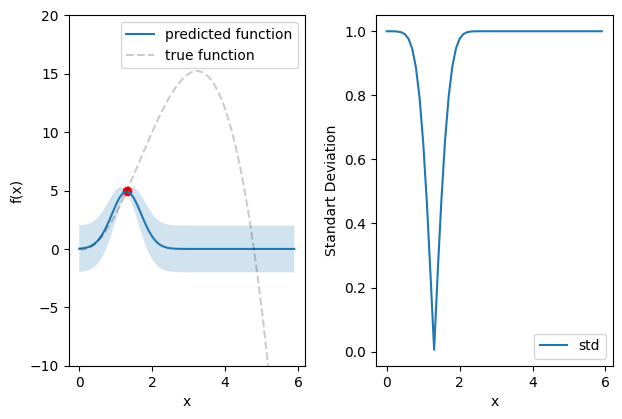

In [12]:
fig, axes  = plt.subplots(1,2)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, wspace=0.3)

axes[0].plot(xx, mus, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        mus - 2*stds,  # 95% confidence interval
        mus + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].set_ylim(-10,20)
axes[1].plot(xx, stds, label='std')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('Standart Deviation')


4.) / 1.)
Now we need to select the newest point: For this, find the point with the most merit:
We can do this on the whole domain, as now the evaluation of the GP is (comperatively) cheap!
(In this example, the most merit is just the most reduction of variance, )

For this we use the expected integrated standard deviation as a Loss:
$$\mathcal L = \int \sigma_{x,x} p(\sigma_xx |\tilde{D}) dx,$$
where $\tilde{D}$ is the new Conditioning of the Gaussian Process. 
The Merit function is then just the inverse, $M = 1/\mathcal{L}$, hence maximizing the Merit is equivalent to minimizing the Loss $\mathcal{L}$.

We want the newest point to be the one which minimizes it, while being within our Domain.

In this one dimensional example, we can explicitly search for the optimal choice.
However, in high dimensional problems this already is no longer feasible.
Luckily, our Loss is piecewise Convex (it is convex on the Simplex spanned by the $dim+1$ conditioning points, I believe).
Hence, finding the optimal value in each Simplex is "easy", and we "just" need to repeat that for each Simplex.
Since out Loss is differentiable (yey, this is why we use JAX), we can use Optimizations like Gradient Descent.

In [13]:
# (Gradient descent)
def gradient_descend(x_0, D, domain_limits, epsilon = 1e-5, maxiter = 1000, eta = 0.01):
    x = x_0
    lower_domain_limit, upper_domain_limit = domain_limits
    xx = jnp.arange(lower_domain_limit, upper_domain_limit, (upper_domain_limit - lower_domain_limit)/100)
    #run for as long as we can
    for iter in range(maxiter):
        D_internal = jnp.append(D, x)
        grad = jax.grad(std_loss_calculator, argnums=1)(xx, D_internal, kernel)
        grad = grad.flatten()[-1]
        if jnp.isnan(grad).any():
            print(f"grad is NAN at {x}, D: {D}")
            break
        #early stopping conditions
        if abs(grad) < epsilon:
            hess = jax.hessian(std_loss_calculator, argnums=1)(xx, D_internal, kernel)
            if hess.flatten()[0] > 0:
                print(f"grad {grad} smaller epsilon {epsilon}, early stopping at {x}")
            break
        
        delta_x = eta * grad
        #print(f"Loss: {loss} deltax: {delta_x}, grad: {grad}, hess: {hess}")
        #outside of domain: bring back into domain
        if x - delta_x < lower_domain_limit:
            x = (x - lower_domain_limit) /2 + lower_domain_limit
            break

        elif x - delta_x > upper_domain_limit:
            x = (upper_domain_limit - x )/2 + x
            break   
        else:
            x = x - delta_x
        
    return x

In [14]:
gradient_descend( jnp.array(1.105), D, (lower_domain_limit, upper_domain_limit), maxiter=100, eta = 0.05)

Array(0.59581531, dtype=float64)

Great, it found something! Let us now do the Gradient Descent on each Simplex, that is in $1-D$ each interval $[l, x_1], [x_1, x_2] \dots [x_n, r]$, where $l$ and $r$ are the domain boundaries.

As a staring point, let us choose the middle of each Simplex.

In [15]:
def x_midpoints(D, domain):
    lower_domain_limit, upper_domain_limit = domain
    x_initials = []
    D = jnp.sort(D)
    for i in range(len(D)+1):
        x_i = 0
        if i == 0:
            x_i = (D[0] - lower_domain_limit)/2 + lower_domain_limit
        elif i == len(D):
            x_i = (upper_domain_limit - D[-1])/2 + D[-1]
        else:
            x_i = (D[i] - D[i-1])/2 + D[i-1]
        x_initials.append(x_i)
    return jnp.array(x_initials)

In [16]:

x_initials = x_midpoints(D, (lower_domain_limit, upper_domain_limit))

In [17]:
x_initials

Array([0.64888636, 3.64888636], dtype=float64)

In [18]:
proposed_xs = jnp.array([gradient_descend(x_i, D, (lower_domain_limit, upper_domain_limit), maxiter=100, eta=5e-3) for x_i in x_initials])

Now let us choose the point of the highest merit of these proposed points:

In [19]:
losses = jnp.array([std_loss_calculator(xx_fine, jnp.append(D, jnp.array(x)), kernel) for x in proposed_xs])
best_x = proposed_xs[jnp.argmin(losses)]

The proposed point $x_{\text{proposed}}$ is now a point of maximum Merit! (in the sense that we found it with gradient descent and merit means less total variance if we condition on it...)
In this simple example, it is feasible to just iterate through a fine grid, e.g. xx (which we use to evaluate the loss anyways...)

Text(0.5, 0, 'x')

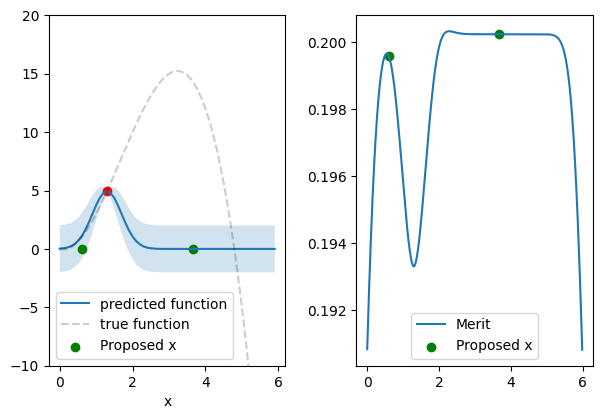

In [20]:
iter_loss = lambda x: partial(std_loss_calculator, xx=xx_fine, kernel=kernel)(D = jnp.append(D, jnp.array(x)))
domain_losses = jax.vmap(iter_loss)(xx_fine)
fig, axes  = plt.subplots(1,2)
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, wspace=0.3)

axes[0].plot(xx, mus, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        mus - 2*stds,  # 95% confidence interval
        mus + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].scatter(jnp.array(proposed_xs), jnp.zeros_like(jnp.array(proposed_xs)), color='green', label='Proposed x')
axes[0].set_ylim(-10,20)
axes[1].plot(xx_fine, 1/domain_losses, label='Merit')

axes[1].scatter(jnp.array(proposed_xs), (1/ jnp.array(losses)), color='green', label='Proposed x')

axes[0].legend()
axes[1].legend()

axes[0].set_xlabel('x')



But how good is our guess?

We are lucky and indeed found the best possible next position (in terms of merit). However, in non convex optimization problems this is not guarenteed! (otherwise I would be jobless, so thats a good thing.)

For now, let us add the condition on $x_{\text{proposed}}$ and call it a day.

In [21]:
D = jnp.append(D, best_x)
#calculate the new f(x_proposed) aswell!
fd = jnp.append(fd, f(best_x))
#obtain new predictor
L = jnp.linalg.cholesky(Gram_XX(D, kernel))
mus = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
stds = jnp.sqrt(jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, L))


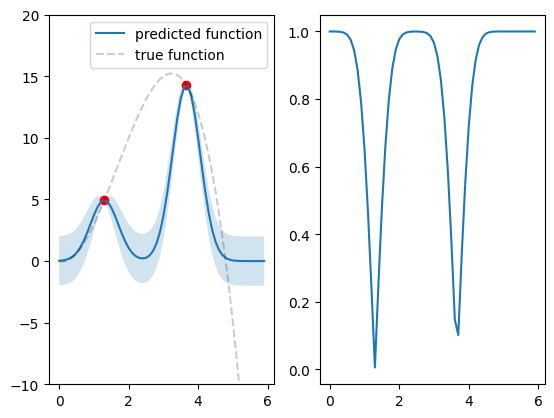

In [22]:
fig, axes  = plt.subplots(1,2)

axes[0].plot(xx, mus, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        mus - 2*stds,  # 95% confidence interval
        mus + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].set_ylim(-10,20)
axes[0].legend()
axes[1].plot(xx, stds, label='Variance')

Now that we have an Idea of how this works, lets add it all together into a single algorithm:

In [23]:
def active_learner(f, N, domain_limits, kernel, key = jax.random.PRNGKey(0)):
    #N: number of supporting points
    #f: function we wish to approximate
    #domain_limits: tuple of lower and upper domain limits
    #kernel: kernel function
    lower_domain_limit, upper_domain_limit = domain_limits
    xx = jnp.arange(lower_domain_limit, upper_domain_limit, (upper_domain_limit-lower_domain_limit)/100)
    xx_fine = jnp.arange(lower_domain_limit, upper_domain_limit, (upper_domain_limit-lower_domain_limit)/1000)

    x_0 = jax.random.uniform(key, (1,), minval = lower_domain_limit, maxval = upper_domain_limit)
    y_0 = f(x_0)
    D = jnp.array(x_0)
    fd = jnp.array(y_0)

    for i in range(N):
        D, fd = __active_learner_step(f, D, fd, domain_limits, kernel, key)
        
    return D, fd

def __active_learner_step(f, D, fd, domain_limits, kernel, key):
    x_initials = x_midpoints(D, domain_limits)
    proposed_xs = jnp.array([gradient_descend(x_i, D, domain_limits, maxiter=100, eta=5e-3) for x_i in x_initials])
    #let us shuffle the proposed xs, so we dont always pick the first one in case the losses are the same. (that is, if we have no clue where to pick anyway, chose a random point rather than the leftmost)
    proposed_xs = jax.random.permutation(key, proposed_xs)
    losses = jnp.array([std_loss_calculator(xx_fine, jnp.append(D, jnp.array(x)), kernel) for x in proposed_xs])
    
    best_x = proposed_xs[jnp.argmin(losses)]
    D = jnp.append(D, best_x)
    fd = jnp.append(fd, f(best_x))
    return D, fd

In [24]:
D_learned, fd_learned = active_learner(f, 5, (0,6), kernel, key = jax.random.PRNGKey(0))

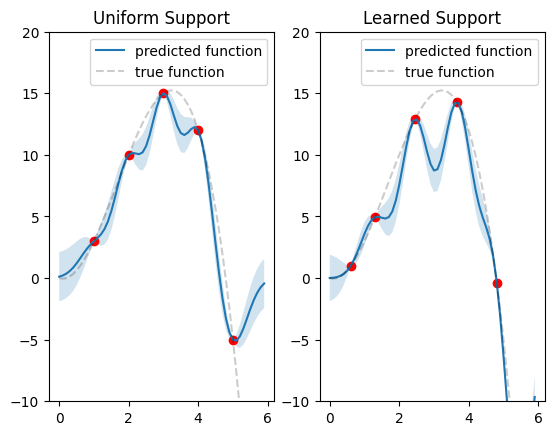

In [25]:
D = jnp.array([1., 2., 3., 4., 5.])
fd = jnp.array([f(x) for x in D])

fig, axes  = plt.subplots(1,2)
L = jnp.linalg.cholesky(Gram_XX(D, kernel))
ys = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, L)
stds = jnp.sqrt(vars)

axes[0].plot(xx, ys, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].set_ylim(-10,20)
axes[0].set_title("Uniform Support")
axes[0].legend()


L = jnp.linalg.cholesky(Gram_XX(D_learned, kernel))
ys = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D_learned, fd_learned, jnp.zeros(fd_learned.shape), kernel, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D_learned, kernel, L)
stds = jnp.sqrt(vars)

axes[1].plot(xx, ys, label='predicted function')
axes[1].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[1].fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
axes[1].scatter(D_learned, fd_learned, color='red')
axes[1].set_ylim(-10,20)
axes[1].set_title("Learned Support")
axes[1].legend()

We see that in both cases our function is drawn too much towards the 0, the prior mean. Reason for this is a too short lengthscale.
Ofcourse we could now manually change the lengthscale a better value.
Or, we do the ML approach and fit it. For this, we do leave one out cross validation, and take as a loss the sum of the negative log likelihood:
$$\mathcal{L} = -\sum_i log(p_\text{GP}(x_i|D/\{x_i\}, l)) $$
We can than mimimize this w.r.t. $l$.

In [26]:
#Jitting is not really worth it, as we need to recompile it for each kernel; hence a lot of the times
#We could specialize it all to the RBF kernel, however this requires rewriting all of the other functions used above.
#@partial(jax.jit, static_argnames=['kernel'])
def loglike(x, x_fd, D, fd, kernel):
    L = jnp.linalg.cholesky(Gram_XX(D, kernel))
    mus = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(x, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
    vars = jax.vmap(post_variance, (0, None, None, None))(x, D, kernel, L)
    stds = jnp.sqrt(vars)
    return -(jax.scipy.stats.norm.logpdf(x_fd, mus, stds))

#Jitting is not really worth it, as we need to recompile it for each kernel; hence a lot of the times
# @partial(jax.jit, static_argnames=['nct','kernel'])
def cross_validation_loss(nct, D, fd, kernel):
    #nct number of crossvalidation targets, #currently only supports leave-one-out-crossvalidation
    #D: support points
    #fd: function values at support points
    #kernel: kernel function
    if nct != 1:
        raise NotImplementedError("Currently only supports leave-one-out-crossvalidation")
    
    n = len(D)
    for i in range(n):
        D_i = jnp.delete(D, i)
        fd_i = jnp.delete(fd, i)
        x = D[i].reshape(1,)
        y = fd[i].reshape(1,)
        loglike_i = loglike(x,fd, D_i, fd_i, kernel)
        loglike_i = loglike_i.flatten()
        if i == 0:
            loglikes = loglike_i
        else:
            loglikes = jnp.append(loglikes, loglike_i)
    
    return jnp.mean(loglikes)

def __rbf__cv(D, fd, l):
    kernel = lambda x,y : rbf_kernel(x,y, l=l)
    return cross_validation_loss(1, D, fd, kernel)

def RBF_learner(D, fd, l0, maxiter = 100, eta = 0.01, max_delta = 1, min_delta = 1e-5, callback=None):
    #D: support points
    #fd: function values at support points
    #l0: initial lengthscale of the RBF kernel; to be learned
    #key: random key

    #Newton with Lr
    l = l0
    s2 = 0,
    s1 = 0
    sc = 0
    for i in range(maxiter):
        val, grad = jax.value_and_grad(__rbf__cv, argnums=2)(D, fd, l)
        if jnp.isnan(grad).any():
            print(f"grad is NAN at {l}")
            break

        
        #This suffers from exploding gradients, hence we do gradient clipping as a first aid fix
        delta_l = val/grad
        if jnp.abs(delta_l) > max_delta:
            delta_l = jnp.sign(delta_l) * max_delta


        #We also want to stop the algorithm from cycling around the found minimum. For this, we reduce the learning rate, whenever we detect a cyclic structure
        # Note that we consider something cyclic already if we swap the sides in a cyclic manner, the values themselves are neglected, so it could in principlen be that we are converging already...

        #update signs:
        s2 = s1
        s1 = sc
        sc = jnp.sign(delta_l)

        if jnp.abs(eta * delta_l) < min_delta:
            break
        
        if s1 != sc and  sc == s2:
            eta = eta*0.8

        l = l - eta * delta_l

        if callback is not None:
            callback(l, val, grad)
    return l






In [27]:
#a sideeffect function! fun!
values_history = []
losses_history = []
def history_callback(l, val, grad):
    values_history.append(l)
    losses_history.append(val)

RBF_learner(D, fd, 0.1, maxiter = 100, eta = 0.1, max_delta = 1, callback=history_callback)

Array(0.60774382, dtype=float64)

In [28]:
import matplotlib.animation as animation

ls = jnp.arange(0.1, 1, 0.01)
losses = jax.vmap(__rbf__cv,(None, None, 0))(D, fd, ls)
lossesv2, _ = jax.vmap(jax.value_and_grad(__rbf__cv, argnums=2), (None, None, 0))(D, fd, ls)
fig, ax = plt.subplots(dpi=300)
ax.plot(ls, losses)
ax.set_xlabel('Lengthscale')
ax.set_ylabel('Loss')
scat = ax.scatter([],[], color='red')

def animate(frame):
    scat.set_offsets(jnp.column_stack([values_history[frame], losses_history[frame]]))
    return scat

anim = animation.FuncAnimation(fig, animate, frames=len(values_history)-1, interval=100)
anim.save('RBF_learner.gif')
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


In [29]:
import time
from IPython.display import HTML
class PlotDisplay:
    def __init__(self):
        self.timestamp = 0
        
    def update(self):
        self.timestamp = int(time.time() * 1000)
        
    def show(self, filename, width=600, height=None):
        if height is None:
            #16-9 aspect ratio by default
            height = width/16*9
        return HTML(f'''
        <div style="text-align: center">
            <img src="{filename}?v={self.timestamp}" width="{width}"/>
        </div>
        ''')


In [30]:
plt_dis = PlotDisplay()
plt_dis.update()
plt_dis.show('RBF_learner.gif')

Great! Now That we know how to do both, kernel learning (at the example of learning the lengthscale of the RBF kernel), and active learning (at the example of the GP above), let us combine both into a semi-blackbox algorithm:

In [31]:
def bb_RBF(n, f, domain_limits, l0=0.3, key = jax.random.PRNGKey(0), max_delta = 1, leta = 0.01):
    #step one: choose an initial point and lengthscale
    lower_domain_limit, upper_domain_limit = domain_limits
    D = jax.random.uniform(key, (1,), minval = lower_domain_limit, maxval = upper_domain_limit)
    fd = jnp.array(f(D))
    l = l0
    kernel = lambda x,y : rbf_kernel(x,y, l=l)
    #step two: find another point
    D, fd = __active_learner_step(f, D, fd, domain_limits, kernel, key)
    for i in range(n-2):
        #beginning with two points we can do the lengthscale optimization
        l = RBF_learner(D, fd, l, max_delta = max_delta, eta = leta)
        print(f"l: {l}")
        kernel = lambda x,y : rbf_kernel(x,y, l=l)
        D, fd = __active_learner_step(f, D, fd, domain_limits, kernel, key)
    
    return D, fd, l, kernel

In [32]:
D_learned, fd_learned, lengthscale_learned, kernel_learned = bb_RBF(5, f, (0,6), l0=0.3)

l: 0.530485925035479
l: 0.412725968961697
l: 0.6531554762470927


In [33]:
#Show the automaticcally learned stuff:
D = jnp.array([1., 2., 3., 4., 5.])
fd = jnp.array([f(x) for x in D])
kernel = lambda x,y : rbf_kernel(x,y, l=0.4)
fig, axes  = plt.subplots(1,2, dpi=300, figsize=(16,9))
L = jnp.linalg.cholesky(Gram_XX(D, kernel))
ys = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, L)
stds = jnp.sqrt(vars)

axes[0].plot(xx, ys, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].set_ylim(-10,20)
axes[0].set_title(f"Uniform Support, l: 0.4")
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[0].legend()


L = jnp.linalg.cholesky(Gram_XX(D_learned, kernel_learned))
ys = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D_learned, fd_learned, jnp.zeros(fd_learned.shape), kernel_learned, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D_learned, kernel_learned, L)
stds = jnp.sqrt(vars)

axes[1].plot(xx, ys, label='predicted function')
axes[1].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[1].fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
axes[1].scatter(D_learned, fd_learned, color='red')
axes[1].set_ylim(-10,20)
axes[1].set_title(f"Learned Support, l: {round(lengthscale_learned, ndigits=2)}")
axes[1].set_xlabel('x')
axes[1].legend()
plt.savefig("bb_RBF.png")
plt.close()



In [34]:
plt_dis = PlotDisplay()
plt_dis.update()
plt_dis.show("bb_RBF.png", width=1200)

In [35]:
D

Array([1., 2., 3., 4., 5.], dtype=float64)

For funs and giggles, lets do a larger (still 1d) problem:

In [36]:
def g(x):
    return jnp.sin(x) + 0.1*x - jnp.sqrt(x)

domain = (0, 100)

D_learned, fd_learned, lengthscale_learned, kernel_learned = bb_RBF(15, g, domain, l0=3., max_delta = 2, leta = 0.1, key = jax.random.PRNGKey(1001))

l: 22.036799999999953
l: 15.300971452427486
l: 8.626106805697386
l: 3.8641193553698634
l: 1.2213910401233485
l: 1.142881030881003
l: 0.20279542542980042
l: 0.21464380201766234
l: 0.27095948175799833
l: 0.3189312802076841
l: 0.3075612413610444
l: 0.32156634622927727
l: 0.3296922273083744


In [37]:
#Show the automaticcally learned stuff:
D = jnp.arange(0, 100, 100/15)
fd = jnp.array([g(x) for x in D])
xx =  jnp.arange(0, 100, 0.1)
yy = jnp.array([g(x) for x in xx])
kernel = lambda x,y : rbf_kernel(x,y, l=5)
fig, axes  = plt.subplots(1,2, dpi=300, figsize=(16,9))
L = jnp.linalg.cholesky(Gram_XX(D, kernel))
ys = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D, fd, jnp.zeros(fd.shape), kernel, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D, kernel, L)
stds = jnp.sqrt(vars)

axes[0].plot(xx, ys, label='predicted function')
axes[0].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[0].fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
axes[0].scatter(D, fd, color='red')
axes[0].set_ylim(-5,4)
axes[0].set_title(f"Uniform Support, l: 0.4")
axes[0].set_xlabel('x')
axes[0].set_ylabel('g(x)')
axes[0].legend()


L = jnp.linalg.cholesky(Gram_XX(D_learned, kernel_learned))
ys = jax.vmap(posterior_mean, (0, None, None, None, None, None, None))(xx, jnp.array(0.), D_learned, fd_learned, jnp.zeros(fd_learned.shape), kernel_learned, L)
vars = jax.vmap(post_variance, (0, None, None, None))(xx, D_learned, kernel_learned, L)
stds = jnp.sqrt(vars)

axes[1].plot(xx, ys, label='predicted function')
axes[1].plot(xx, yy, color='black', alpha=0.2, ls='--', label='true function')
axes[1].fill_between(
        xx, 
        ys - 2*stds,  # 95% confidence interval
        ys + 2*stds,
        alpha=0.2    # transparency
    )
axes[1].scatter(D_learned, fd_learned, color='red')
axes[1].set_ylim(-5,4)
axes[1].set_title(f"Learned Support, l: {round(lengthscale_learned, ndigits=2)}")
axes[1].set_xlabel('x')
axes[1].legend()
plt.savefig("bb_RBF_g.png")
plt.close()



In [38]:
plt_dis = PlotDisplay()
plt_dis.update()
plt_dis.show("bb_RBF_g.png", width=1200)

We see that the algorithm has a hard time with trying to fit the function. The reason for this is the complexity of our Kernel function:
In Real World problems, you will want to implement Kernel learning for more sophisticated kernels. In this example, a periodic (ideally sinusoidal) kernel would be needed. We will not extend upon this limitation in this notebook, but hopefully this notebook gave you some Ideas on how to do that!